# Evoluční algoritmy - spojitá optimalizace

Minule jsem si ukazovali jednoduchý genetický algoritmus, který pracoval s binárními jedinci. Dnes se podíváme na spojité reprezentace jedinců a na další druhy evolučních operátorů.

## Minimalizace Rastrigin funkce

V následujícím cvičení si vyzkoušíme napsat jednoduchý evoluční algoritmus pro minimalizaci [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function). Tato funkce je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Nalezení jejího minima je složité, protože obsahuje spoustu lokálních minim. 



In [2]:
import random
import copy
import math

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Nejprve si definujeme, jak tedy vypadá ona výše zmíněná funkce, kterou budeme chtít minimalizovat. Potom je třeba si rozmyslet, jak bude vypadat jedinec. Pro nás to teď bude floating point vektor, kde hodnoty budou čísla z intervalu [-5.12,5.12]. Pro něj si napíšeme svoje operátory křížení a mutace. Křížení může být aritmetické, například vážený průměr dvou jedinců, nebo strukturální, kdy opět prohazujeme části jedinců. Mutace může být buď nezatížená (unbiased), což znamená, že se pro mutovanou pozici vygeneruje nové číslo uniformě z daného rozsahu hodnot, nebo zatížená (biased), kdy k hodnotě v jedinci přičtu nějaké číslo z normálního rozdělení s danou odchylkou (například 1) a nulovou střední hodnotou.

In [3]:
# Value of a fitness function will be the value of Rastrigin function in the given point
# But we want to change minimization of the function to maximization of the fitness, thus we return minus the value
def fitness(individual):
    N = len(individual)
    A = 10
    
    value = A * N
    for i in range(len(individual)):
        value += (individual[i] * individual[i]) - A * math.cos(2 * math.pi * individual[i])
        
    return -value


# Unbiased mutation
def mutation_unbiased(population, individual_mutation_prob=0.2, value_mutation_prob=0.1):
    new_population = []
    
    for i in range(len(population)):
        individual = population[i]
        
        if random.random() < individual_mutation_prob:
            individual = copy.deepcopy(individual)
            
            for i in range(len(individual)):
                if random.random() < value_mutation_prob:
                    individual[i] = np.random.uniform(-5.12, 5.12)
                    
        new_population.append(individual)
        
    return new_population


# Arithmetic crossover
def crossover_arithmetic(population, cross_prob=0.8, alpha=0.25):
    new_population = []
    
    for i in range(len(population)//2):
        individual1 = population[2*i]
        individual2 = population[2*i+1]
        
        if random.random() < cross_prob:
            # Either, we could do this bit by bit like this (which is quite slow):
            # child1 = copy.deepcopy(individual1)
            # child2 = copy.deepcopy(individual2)
            #
            # for i in range(len(individual1)):
            #     child1[i] = alpha * individual1[i] + (1-alpha) * individual2[i]
            #     child2[i] = (1-alpha) * individual1[i] + alpha * individual2[i]
            
            # Or we can take advantage of the fact we are using NumPy arrays, like this:
            # (The sum of arrays returns a new array, so there is no need for the deepcopy)
            child1 = alpha * individual1 + (1-alpha) * individual2
            child2 = (1-alpha) * individual1 + alpha * individual2
                
        else:
            child1 = individual1
            child2 = individual2
                
        new_population.append(child1)
        new_population.append(child2)
        
    return new_population


# Population intialization (random)
def random_population(population_size, individual_size):
    return list(np.random.uniform(-5.12, 5.12, size=(population_size, individual_size)))


# Tournament selection
def tournament_selection(population, fitness_value, k): 
    new_population = []
    
    for _ in range(len(population)):
        indices = np.random.choice(len(population), size=k, replace=False)
        individuals = [population[idx] for idx in indices]
        fitnesses = [fitness_value[idx] for idx in indices]
            
        new_population.append(individuals[np.argmax(fitnesses)])
        
    return new_population 

Nyní si stejně jako v minulé hodině definujeme celý evoluční algoritmus a pak ho pustíme a sledujeme, co se bude dít.

In [4]:
def evolution(population_size, individual_size, max_generations):
    max_fitness = []
    population = random_population(population_size,individual_size)
    
    for _ in range(max_generations):
        fitness_value = list(map(fitness, population))
        max_fitness.append(max(fitness_value))
        
        parents = tournament_selection(population, fitness_value, 2)
        children = crossover_arithmetic(parents)
        mutated_children = mutation_unbiased(children)
        
        population = mutated_children
        
    # We compute fitness for the last population and obtain the best individual
    fitness_value = list(map(fitness, population))
    max_fitness.append(max(fitness_value))
    best_individual = population[np.argmax(fitness_value)]
    
    return best_individual, population, max_fitness

Best fitness: -6.861681427138889
Best individual: [ 0.01222721  0.02391045  0.05206598 -1.01670255  0.00982621 -0.05885702
  0.01377195  0.08989679  0.95116857  0.08586528]


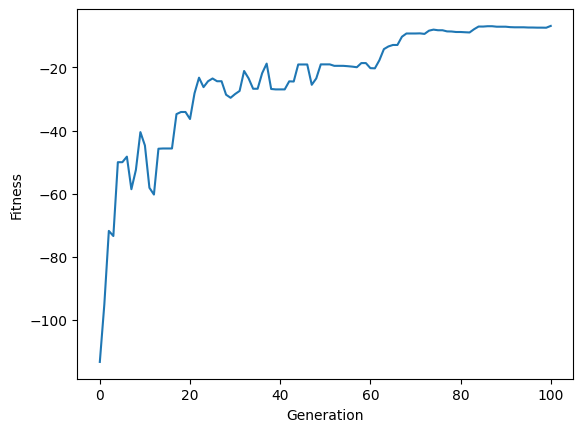

In [5]:
best, population, max_fitness = evolution(population_size=100, individual_size=10, max_generations=100)

print("Best fitness:", fitness(best))
print("Best individual:", best)


plt.plot(max_fitness)
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.show()


## Úkol na cvičení

V kódu výše je naprogramovaná nejjednodušší mutace - nezatížená. Zkuste si napsat alespoň dva další druhy mutace z následujích možností a porovnat, jak se bude evoluční algoritmus chovat.
1. Zatížená mutace, kdy se k hodnotě v jedinci přičítá číslo z normalního rozdělení se střední hodnotou 0 a rozptylem sigma. Sigma se třeba navíc může během každých n generací postupně snižovat. 

2. Mutace s 1/5 pravidlem, která se používá hlavně u evolučních strategií a probíhá podobně jako zatížená mutace - přičítá k hodnotě číslo z náhodného rozdělení se střední hodnotou 0 a rozptylem sigma. Sigma se updatuje v každém kroku následovně: Při každé mutaci se podívám, jestli je výsledný jedinec lepší, než co jsem měl před mutací. Pokud ano, říkám, že je mutace úspěšná. V průběhu celé iterace si zapamatuji poměr úspěšných mutací *p* (tedy počet úspěšných mutací ku počtu všech mutací). Sigmu pak upravíme pomocí jednoduché rovnice: sigma = sigma \* e^(*p*-1/5). \
(Ergo pokud jsem v této iteraci nageneroval mutací víc jak pětinu jedinců takovou, že jsou lepší než jedinci, které jsem už měl před mutací, sigma se zvýší (-> vyšší explorace), jinak se sigma sníží (-> vyšší exploitace).)

3. Mutace z diferenciální evoluce, která vybere náhodně pro daného jedince dva další, dělá rozdíl jejich hodnot (složku po složce) a ten navíc vynásobí nějakou konstantou (třeba 0.8) a to pak přičte k hodnotám v původním jedinci.

Můžete samozřejmě zkusit vymyslet i nějakou vlastní mutaci, nebo třeba zkusit vypnout mutaci nebo vypnout křížení a sledovat, co se bude s evolucí dít.

## Deap knihovna

Nyní si opět vyzkoušíme přepsat výše zmíněný problém minimalizace Rastrigin funkce pomocí operátorů knihovny DEAP, abychom si lépe vyzkoušeli, jak se s ní pracuje a jak v ní tvořit svoje vlastní operátory, které se nám budou hodit příští hodinu u genetického programování.

In [6]:
from deap import algorithms, base, creator, tools

Pro jistotu si znovu definujeme vlastní funkce mutace, křížení a fitness funkci.

In [8]:
def rastring_function(individual):
    N = len(individual)
    A = 10
    
    value = A * N
    for i in range(len(individual)):
        value += (individual[i] * individual[i]) - A * math.cos(2 * math.pi * individual[i])
        
    return value,


def mutation_unbiased(individual, value_mutation_prob):
    for i in range(len(individual)):
        if random.random() < value_mutation_prob:
            individual[i] = np.random.uniform(-5.12, 5.12)
            
    return individual,


def crossover_arithmetic(individual1, individual2, alpha=0.25):
    # We will be working with python lists, so we cannot use the NumPy hack we used before and must do this bit by bit
    child1 = copy.deepcopy(individual1)
    child2 = copy.deepcopy(individual2)
    
    for i in range(len(individual1)):
        child1[i] = alpha * individual1[i] + (1-alpha) * individual2[i]
        child2[i] = (1-alpha) * individual1[i] + alpha * individual2[i]
        
    return child1, child2

Pak si zadefinujeme nový toolbox a přídáme do něj naše operátory. 

In [10]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 because we want to minimize the function
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_float", random.uniform, -5.12, 5.12)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", rastring_function)
toolbox.register("mate", crossover_arithmetic)
toolbox.register("mutate", mutation_unbiased, value_mutation_prob=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)


Na závěr pustíme celou evaluci a můžeme sledovat, jak se nám hledání minima daří, nebo případně nedaří.

In [11]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	300   	73.0567	19.4704	25.0103	116.457
1  	256   	56.2071	16.4258	13.7678	106.264
2  	259   	48.5835	14.8392	13.31  	89.8955
3  	256   	43.2293	14.4135	8.31198	80.1734
4  	266   	41.0632	15.1432	6.24147	85.5699
5  	262   	39.1342	13.753 	9.12785	84.5177
6  	245   	36.6278	13.35  	7.90171	74.2629
7  	269   	34.2164	14.0832	5.22076	77.2599
8  	245   	30.1426	13.9824	6.79624	80.2858
9  	233   	23.8092	12.6824	1.93707	68.3719
10 	254   	20.0475	11.7828	0.0902486	67.7389
11 	241   	14.4574	10.1145	0.57319  	49.3555
12 	249   	10.1375	9.20175	0.282102 	51.1477
13 	257   	5.29567	7.22435	0.0799386	41.2834
14 	249   	2.74288	6.74701	0.0799386	56.6358
15 	272   	2.16907	6.80812	0.0541747	44.4668
16 	258   	1.69653	6.13337	0.0168885	40.3792
17 	256   	1.08776	5.5174 	0.0114803	61.1627
18 	258   	1.84675	7.18856	0.0104199	55.5742
19 	255   	1.94967	6.99533	0.0104199	48.1466
20 	254   	1.44231	6.10522	0.0111179	40.3737
21 	253   	1.71429	7.6083 	0.008